In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

#### Main functions

In [2]:
def fp_bias(e_bit):
    return (1 << (e_bit - 1)) - 1

def fp_nmax(e_bit, m_bit, support_special_values = False):
    bias = fp_bias(e_bit)
    max_exp = (1 << e_bit) - 1 - bias
    if support_special_values:
        max_exp -= 1

    max_frac = ((1 << (m_bit + 1)) - 1) / (1 << m_bit)
    return max_frac * (2**max_exp)

def fp_nmin(e_bit):
    bias = fp_bias(e_bit)
    min_exp = 1 - bias
    return 1.0 * (2**min_exp)

def fp_round(   x,
                scale,
                mu,
                e_bit,
                m_bit,
                support_special_values = False):
    x -= mu
    x /= scale
    nmax = fp_nmax(e_bit, m_bit, support_special_values)
    nmin = fp_nmin(e_bit)
    # saturate when overflow
    x_overflow = torch.sign(x) * nmax
    # sub-normal login when underflow
    fraction_size = 1 << m_bit
    x_underflow_scaled = torch.round(x / nmin * fraction_size)
    x_underflow = x_underflow_scaled * nmin / fraction_size
    # Round data with full exponent range 
    _, x_exp = torch.frexp(x)
    x_normal = torch.round(x * 2**(-x_exp)) * 2**(x_exp)
    x = torch.where(torch.abs(x) > nmax, x_overflow, x_normal)
    x = torch.where(torch.abs(x) < nmin, x_underflow, x)

    return x * scale + mu

def fp_round_error( x,
                    scale, 
                    mu, 
                    e_bit, 
                    m_bit, 
                    support_special_values = False,
                    ridge_lambda = 0.0,
                    barrier_nu = 0.0):
    # relying on pytorch broadcasting
    y = (x - mu) / scale
    nmax = fp_nmax(e_bit, m_bit, support_special_values) 
    nmin = fp_nmin(e_bit) 
    eps = 2**(-m_bit - 1)

    # overflow error
    Overflow_err = torch.abs(x - mu) - (1-eps) * nmax * scale
    ridge_error = ridge_lambda * (y/nmax + 1) * (y/nmax - 1)
    underflow_err = eps * scale + ridge_error

    err = torch.abs(x - mu) * eps + ridge_error
    err = torch.where(torch.abs(y) < nmin, underflow_err, err)
    err = torch.where(torch.abs(y) > nmax, Overflow_err, err)

    return err - barrier_nu * eps/nmax * torch.log(scale)

def fi_max(m_bit):
    return (1 << (m_bit - 1)) - 1

def fi_min(m_bit):
    return -(1 << (m_bit - 1))

def fi_round(x, 
             scale,
             mu,
             m_bit,
             ):
    x = (x - mu) / scale
    x_fi_max = fi_max(m_bit)
    x_fi_min = fi_min(m_bit)
    x = torch.round(x)
    x = torch.where(x > x_fi_max, x_fi_max, x)
    x = torch.where(x < x_fi_min, x_fi_min, x)

    return x * scale + mu

# Ensure we can handle asymmetric nature of fixed point container
# i.e., int2 is [-2,1], int4 is [-8,7], int8 is [-128,127]
# plot the error corresponding to scale, sanity check for convexity.
def fi_round_error(x, 
                   scale, 
                   mu, 
                   m_bit, 
                   ridge_lambda = 0.0, 
                   barrier_nu = 0.0):
    # relying on the pytorch broadcasting
    y = (x - mu) / scale
    y_fi_max = fi_max(m_bit)
    y_fi_min = fi_min(m_bit)

    y_mu = (y_fi_max + y_fi_min) / 2
    y_diff = (y_fi_max - y_fi_min) / 2

    underflow_err = 0.5 + ridge_lambda * ((y - y_mu)/y_diff + 1) * ((y-y_mu)/y_diff - 1)
    pos_overflow_err = y - y_fi_max + 0.5
    neg_overflow_err = -y + y_fi_min + 0.5
    err = torch.where(y > y_fi_max, pos_overflow_err, underflow_err)
    err = torch.where(y < y_fi_min, neg_overflow_err, err)

    return err * scale - barrier_nu * 0.5 / y_fi_max * torch.log(scale)
    

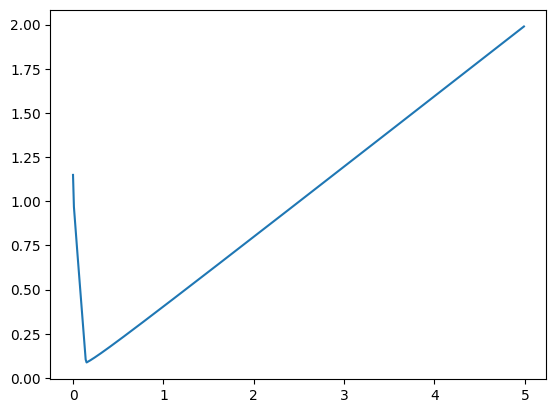

In [3]:
scales = torch.arange(-5.0, 5.0, 0.01)
errors = torch.tensor([fi_round_error(torch.tensor(1.0), s, 0.0, 4, 0.1, 0.1) for s in scales])
plt.plot(scales, errors)

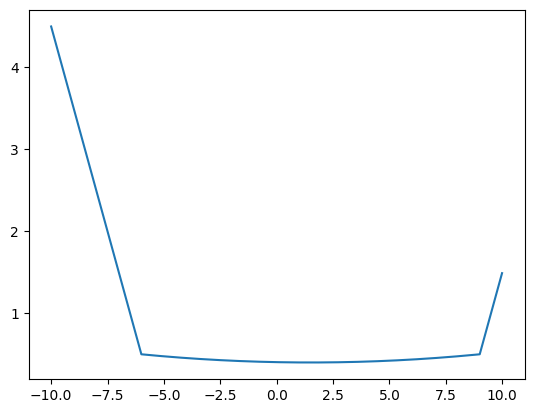

In [4]:
mus = torch.arange(-10.0, 10.0, 0.01)
errors = torch.tensor([fi_round_error(torch.tensor(1.0), torch.tensor(1.0), mu, 4, 0.1, 0.1) for mu in mus])
plt.plot(mus, errors)
plt.show()

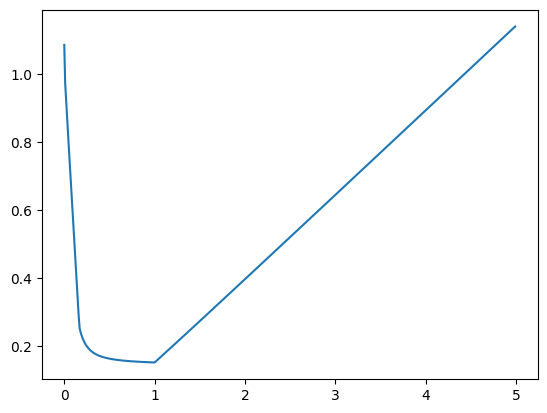

In [5]:
scales = torch.arange(-5.0, 5.0, 0.01)
errors = torch.tensor([fp_round_error(torch.tensor(1.0), s, 0.0, 2, 1, False, 0.1, 0.1) for s in scales])
plt.plot(scales, errors)
plt.show()

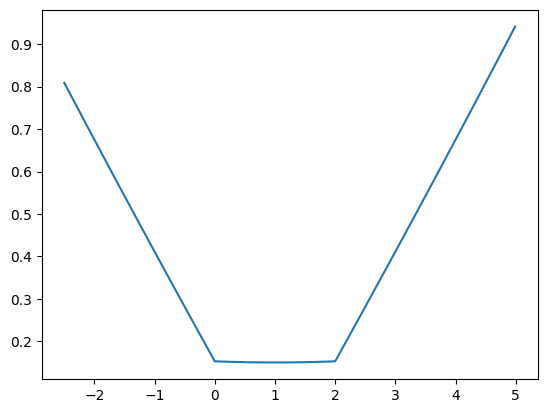

In [6]:
mus = torch.arange(-2.5, 5.0, 0.01)
errors = torch.tensor([fp_round_error(torch.tensor(1.0), torch.tensor(1.0), mu, 2, 1, False, 0.1, 0.1) for mu in mus])
plt.plot(mus, errors)
plt.show()

### loading checkpoint

In [7]:
import pickle as pkl
with open('/workspace/llama3-8b-0-q_proj.pkl', 'rb') as f:
    ffn1 = torch.from_numpy(pkl.load(f)).type(torch.float32)

### Optimize rounding error

In [8]:
fp_nmax(2, 1, False)

6.0

epoch = 0, loss = 0.00251573184505105
epoch = 1, loss = 0.002515044528990984
epoch = 2, loss = 0.002517022890970111
epoch = 3, loss = 0.0025254220236092806
epoch = 4, loss = 0.00253132451325655
epoch = 5, loss = 0.002530429745092988
epoch = 6, loss = 0.0025274688377976418
epoch = 7, loss = 0.0025241440162062645
epoch = 8, loss = 0.002520509297028184
epoch = 9, loss = 0.002516399370506406
epoch = 10, loss = 0.0025113821029663086
epoch = 11, loss = 0.0025066910311579704
epoch = 12, loss = 0.002502572489902377
epoch = 13, loss = 0.0024987193755805492
epoch = 14, loss = 0.0024945600889623165
epoch = 15, loss = 0.0024906436447054148
epoch = 16, loss = 0.002487547229975462
epoch = 17, loss = 0.0024847290478646755
epoch = 18, loss = 0.002481976756826043
epoch = 19, loss = 0.0024798749946057796
epoch = 20, loss = 0.0024779601953923702
epoch = 21, loss = 0.0024764579720795155
epoch = 22, loss = 0.0024751510936766863
epoch = 23, loss = 0.002474220935255289
epoch = 24, loss = 0.002473618602380156

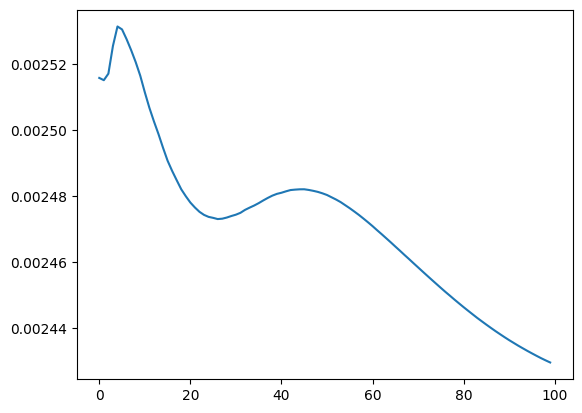

In [12]:
def ffn_fp_round_error(params, x, e_bit, m_bit):
    # depending on the Pytorch broadcasting
    scale = params[0].expand(-1, x.shape[1], -1)
    mu = params[1].expand(-1, x.shape[1], -1)

    return torch.mean(fp_round_error(x, scale, mu, e_bit, m_bit, False, 0.001, 0.001))

# Optimize the rounding error for fp4 e2m1
e_bit = 2
m_bit = 1
BLOCK = 128
# sub-channel shaped ffn1. The dimension is chosen to make MXU matmul easier
b_ffn1 = ffn1.reshape((ffn1.shape[0]//BLOCK, BLOCK, ffn1.shape[1]))

ffn1_max = torch.max(b_ffn1, axis=1, keepdim=True)[0]
ffn1_min = torch.min(b_ffn1, axis=1, keepdim=True)[0]

s = torch.nn.Parameter((ffn1_max - ffn1_min) / 2.0 / fp_nmax(2, 1, False))
mu = torch.nn.Parameter((ffn1_max + ffn1_min) / 2.0)

start_learning_rate = 0.001
params = [s, mu]
optim = torch.optim.Adam(params, lr=start_learning_rate)

s_eps = 1e-5
errs = []
for epoch in range(100):
    loss = ffn_fp_round_error(params, b_ffn1, 2, 1)
    optim.zero_grad()
    loss.backward()
    optim.step()
    params[0].data.clamp_(min=s_eps)

    errs.append(loss.item())
    print(f'{epoch = }, loss = {loss.item()}')

plt.plot(errs)

In [10]:
def ffn_fi_round_error(params, x, m_bit):
    scale = params[0].expand(-1, x.shape[1], -1)
    mu = params[1].expand(-1, x.shape[1], -1)

    return torch.mean(fi_round_error(x, scale, mu, m_bit, 0.01, 0.01))

ffn1.shape
BLOCK = 128
m_bit = 2

# sub-channel shaped ffn1. The dimension is chosen to make MXU matmul easier
b_ffn1 = ffn1.reshape((ffn1.shape[0]//BLOCK, BLOCK, ffn1.shape[1]))

ffn1_max = torch.max(b_ffn1, axis=1, keepdim=True)[0]
ffn1_min = torch.min(b_ffn1, axis=1, keepdim=True)[0]

s = torch.nn.Parameter((ffn1_max - ffn1_min) / 2.0 / fi_max(m_bit))
mu = torch.nn.Parameter((ffn1_max + ffn1_min) / 2.0)

start_learning_rate = 0.001
params = [s, mu]
optim = torch.optim.Adam(params, lr=start_learning_rate)

s_eps = 1e-5
errs = []
for epoch in range(50):
    loss = ffn_fi_round_error(params, b_ffn1, m_bit)
    optim.zero_grad()
    loss.backward()
    optim.step()
    params[0].data.clamp_(min=s_eps)

    errs.append(loss.item())
    print(f'{epoch = }, loss = {loss.item()}')

epoch = 0, loss = 0.039256446063518524
epoch = 1, loss = 0.03810936212539673
epoch = 2, loss = 0.03750281780958176
epoch = 3, loss = 0.03705915808677673
epoch = 4, loss = 0.03669803589582443
epoch = 5, loss = 0.03638686239719391
epoch = 6, loss = 0.03610912710428238
epoch = 7, loss = 0.03585564345121384
epoch = 8, loss = 0.03562038391828537
epoch = 9, loss = 0.035399429500103
epoch = 10, loss = 0.03519011288881302
epoch = 11, loss = 0.0349905900657177
epoch = 12, loss = 0.03479953855276108
epoch = 13, loss = 0.03461609035730362
epoch = 14, loss = 0.03443966060876846
epoch = 15, loss = 0.03426983207464218
epoch = 16, loss = 0.03410631790757179
epoch = 17, loss = 0.033948928117752075
epoch = 18, loss = 0.0337974913418293
epoch = 19, loss = 0.03365182504057884
epoch = 20, loss = 0.03351178020238876
epoch = 21, loss = 0.033377163112163544
epoch = 22, loss = 0.03324773907661438
epoch = 23, loss = 0.03312330320477486
epoch = 24, loss = 0.03300368785858154
epoch = 25, loss = 0.032888762652873

In [11]:
print(s.shape)
print(mu.shape)

torch.Size([32, 1, 4096])
torch.Size([32, 1, 4096])


In [13]:
with torch.no_grad():
    fake_quant_x = fp_round(    b_ffn1,
                                s.expand(-1, b_ffn1.shape[1], -1),
                                mu.expand(-1, b_ffn1.shape[1], -1),
                                e_bit,
                                m_bit,
                                support_special_values = False)

In [14]:
print('fake_quant_x')
print(fake_quant_x)
print('b_ffn1')
print(b_ffn1)

fake_quant_x
tensor([[[-4.8297e-03, -2.5173e-02, -2.8509e-03,  ...,  7.9778e-03,
          -4.7649e-02, -2.1269e-02],
         [-1.0052e-02, -7.1342e-02, -2.8509e-03,  ..., -1.4677e-02,
          -5.1770e-02,  2.1757e-02],
         [-2.0497e-02, -4.3641e-02, -2.8509e-03,  ...,  1.2509e-02,
          -1.0556e-02,  1.1001e-02],
         ...,
         [ 3.1728e-02, -2.5173e-02, -2.0264e-02,  ..., -5.6152e-03,
           1.8081e-03,  2.5343e-02],
         [ 5.6152e-03,  3.9464e-02,  1.4562e-02,  ...,  2.6102e-02,
           3.0658e-02,  1.8172e-02],
         [ 3.9275e-04, -6.7054e-03,  2.9533e-03,  ...,  2.1571e-02,
           1.4172e-02,  2.4414e-04]],

        [[-4.8285e-03, -1.3726e-02, -8.7307e-02,  ...,  4.8118e-02,
           5.4717e-02,  3.4522e-02],
         [ 8.1921e-03,  5.3577e-03, -2.4620e-02,  ...,  1.0994e-02,
           5.4717e-02,  2.1957e-02],
         [ 3.8519e-03,  5.3577e-03, -3.0319e-02,  ...,  4.8063e-03,
           3.0799e-02,  2.1957e-02],
         ...,
         [-9